In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


Bad key "text.kerning_factor" on line 4 in
/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# H2O AutoML framework for benchmarking
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size = 32)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 days 19 hours 29 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,2 months and 12 days
H2O_cluster_name:,H2O_from_python_moc0_j96c9b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.28 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


## Load data

In [3]:
# Define working directory
os.chdir('/home/moc0/ai-vegetation-fuel')

In [4]:
# Load raw train data
train = pd.read_csv(os.getcwd() + "/data/inputs/train_interpTrue_raw.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})
train = train.drop('Unnamed: 0', axis = 1)

# Load raw test data
test = pd.read_csv(os.getcwd() + "/data/inputs/test_interpTrue_raw.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})
test = test.drop('Unnamed: 0', axis = 1)

In [5]:
# Define outcome variable
y = 'dry_matter'

Define possible transformations.

In [6]:
def transform(train, test, features, transformation, output_transformer = False):
    # copy of datasets
    train_transformed = train.copy()
    test_transformed = test.copy()
    if transformation == "log":
        for i in features:
            # transform the training data column
            train_transformed[i] = np.log(train_transformed[[i]])
            # transform the testing data column
            test_transformed[i] = np.log(test_transformed[[i]])
            return train_transformed, test_transformed
    else:
        if transformation == "normalization":
            # data normalization with sklearn
            for i in features:
                # fit on training data column
                transformer = MinMaxScaler()
                norm = transformer.fit(train_transformed[[i]])
                # transform the training data column
                train_transformed[i] = norm.transform(train_transformed[[i]])
                # transform the testing data column
                test_transformed[i] = norm.transform(test_transformed[[i]])
        if transformation == "standardization":
            # data standardization with sklearn
            for i in features:   
                # fit on training data column
                transformer = StandardScaler()
                scale = transformer.fit(train_transformed[[i]])
                # transform the training data column
                train_transformed[i] = scale.transform(train_transformed[[i]])
                # transform the testing data column
                test_transformed[i] = scale.transform(test_transformed[[i]])
        if transformation == "power":
            # PowerTransform with sklearn
            for i in features:
                # fit on training data column
                transformer = PowerTransformer()
                yj = transformer.fit(train_transformed[[i]])
                # transform the training data column
                train_transformed[i] = yj.transform(train_transformed[[i]])
                # transform the testing data column
                test_transformed[i] = yj.transform(test_transformed[[i]])
        if output_transformer == False:
            return train_transformed, test_transformed
        else:
            return train_transformed, test_transformed, transformer

# Run benchmark tests

## STAGE A

### 0. The basic benchmark model

This is given by the regressor model fitted on raw outcome (no target transformation), raw features (no features transformation).

In [7]:
# Define Regressor model
aml = H2OAutoML(max_runtime_secs = 10*60, seed = 1, stopping_metric = "mae",
                preprocessing = ["target_encoding"])
# Fit
aml.train(y = y, training_frame = h2o.H2OFrame(train))

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [8]:
# MAE
obs = test[y]
pre = aml.predict(h2o.H2OFrame(test))
mean_absolute_error(obs, pre.as_data_frame())

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


54.08793142495884

### 1. Log-transform target variable

Assess whether there is an improvement by transforming the target variable. This means comparing the results of a basic model using raw outcome/features versus transformed outcome and raw features.

In [9]:
train_log_target, test_log_target = transform(train = train, test = test,
                                              features = [y], transformation = "log")

In [10]:
# Define Regressor model
aml = H2OAutoML(max_runtime_secs = 10*60, seed = 1, stopping_metric = "mae",
                preprocessing = ["target_encoding"])
# Fit
aml.train(y = y, training_frame = h2o.H2OFrame(train_log_target))

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [11]:
# MAE
pre = aml.predict(h2o.H2OFrame(test_log_target))
pre_inverse_transformed = np.exp(pre.as_data_frame())
mean_absolute_error(obs, pre_inverse_transformed)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


47.763069430447985

### 2. Power-transform target variable

Assess whether there is an improvement by transforming the target variable. This means comparing the results of a basic model using raw outcome/features versus transformed outcome and raw features.

In [12]:
train_power_target, test_power_target, transformer = transform(train = train, test = test,
                                                               features = [y], transformation = "power",
                                                               output_transformer = True)

In [13]:
# Define Regressor model
aml = H2OAutoML(max_runtime_secs = 10*60, seed = 1, stopping_metric = "mae",
                preprocessing = ["target_encoding"])
# Fit
aml.train(y = y, training_frame = h2o.H2OFrame(train_power_target))

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [14]:
# MAE
pre = aml.predict(h2o.H2OFrame(test_power_target))
pre_inverse_transformed = transformer.inverse_transform(pre.as_data_frame())
mean_absolute_error(obs, pre_inverse_transformed)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


48.40078069096282

From the 3 experiments above it seems the best way to transform the target variable is to use the logarithmic function. For this reason, we add to the train and test sets an additional column with the lo-transformed target variable.

In [15]:
train['log_dry_matter'] = np.log(train[y])
test['log_dry_matter'] = np.log(test[y])

In [16]:
train

,latitude,longitude,dry_matter,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,...,dufmcode,drtcode,infsinx,fbupinx,fdsrte,frp,daysElapsed,timeYear,timeMonth,log_dry_matter
0,-32.375,28.125,1.001038,3.0,1.0,9.0,0.014507,0.228241,0.222220,-0.398828,...,13.643188,109.829220,1.191657,22.684143,2.530905,0.000000,212,2010,8,0.001037
1,17.875,82.375,27.360060,4.0,5.0,12.0,0.024084,0.385490,0.555550,-0.349998,...,-43.599540,-57.730576,-3.418025,-41.623190,-7.454767,0.000000,1520,2014,3,3.309084
2,-31.625,28.375,3.641749,3.0,1.0,9.0,0.020789,0.275492,0.288886,-0.404686,...,-13.695341,-106.551190,-0.762760,-19.835646,-1.497616,0.000000,1277,2013,7,1.292464
3,13.375,37.125,17.883150,4.0,1.0,8.0,0.042149,0.256732,0.433329,-0.295313,...,-88.729330,26.709599,1.302401,-74.875960,3.221945,0.000000,455,2011,4,2.883859
4,8.125,-1.625,1.747495,4.0,1.0,8.0,0.006682,0.199548,0.722215,1.403907,...,-128.986300,-210.755860,-1.751252,-125.311600,-7.706358,0.007889,1492,2014,2,0.558184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530027,10.625,-13.875,36.482942,4.0,1.0,8.0,0.008239,0.415102,1.566651,0.874609,...,126.336510,63.899292,1.229383,116.538080,3.192863,0.015762,1216,2013,5,3.596845
530028,-15.375,34.625,1.640657,3.0,1.0,9.0,0.016233,0.205404,1.022212,0.112892,...,-13.123533,22.029633,-1.279937,-11.235716,-2.089784,0.000000,577,2011,8,0.495097
530029,11.875,36.625,13.193764,4.0,1.0,8.0,0.022857,0.218347,0.377774,1.757421,...,6.771729,19.831726,0.491823,4.540405,1.184292,0.000000,1096,2013,1,2.579744
530030,2.875,19.375,850.061983,4.0,5.0,8.0,0.002305,0.789469,1.566651,-0.131250,...,62.941635,53.213240,3.535935,56.135567,7.314124,0.003937,2191,2016,1,6.745309


## STAGE B

Assuming we will always log-transform the target variable (now `log_dry_matter`), in this stage we assess which features should be transformed and how to transform them.

In [17]:
# Re-define outcome variable
y = 'log_dry_matter'

# Skewed features
skewed_features = ['slope', 'vod', 'lai', 'frp']
all_features = ['latitude', 'longitude', 'climatic_region', 'biome', 'GFEDregions', 'slope', 'vod', 'lai',
                'spi03', 'spi06', 'spi12', 'd2m', 'erate', 'fg10', 'si10', 'swvl1', 't2m', 'tprate',
                'danger_risk', 'fwinx', 'ffmcode', 'dufmcode', 'drtcode', 'infsinx', 'fbupinx', 'fdsrte',
                'frp', 'daysElapsed', 'timeYear', 'timeMonth']

trainB = train.drop('dry_matter', axis = 1)
testB = test.drop('dry_matter', axis = 1)

In [18]:
train_norm_skew, test_norm_skew = transform(train = trainB, test = testB,
                                            features = skewed_features, transformation = "normalization")
train_norm_all, test_norm_all = transform(train = trainB, test = testB,
                                          features = all_features, transformation = "normalization")
train_stand_skew, test_stand_skew = transform(train = trainB, test = testB,
                                              features = skewed_features, transformation = "standardization")
train_stand_all, test_stand_all = transform(train = trainB, test = testB,
                                            features = all_features, transformation = "standardization")
train_power_skew, test_power_skew = transform(train = trainB, test = testB,
                                              features = skewed_features, transformation = "power")
train_power_all, test_power_all = transform(train = trainB, test = testB,
                                            features = all_features, transformation = "power")

In [24]:
# Define a list of datasets to work with
trainX = [h2o.H2OFrame(train_norm_skew),
          h2o.H2OFrame(train_norm_all),
          h2o.H2OFrame(train_stand_skew),
          h2o.H2OFrame(train_stand_all),
          h2o.H2OFrame(train_power_skew),
          h2o.H2OFrame(train_power_all)]
testX = [h2o.H2OFrame(test_norm_skew),
         h2o.H2OFrame(test_norm_all),
         h2o.H2OFrame(test_stand_skew),
         h2o.H2OFrame(test_stand_all),
         h2o.H2OFrame(test_power_skew),
         h2o.H2OFrame(test_power_all)]

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
# model fitting and measuring the model metric
mae = []
for i in range(len(trainX)):
    # Define Regressor model
    aml = H2OAutoML(max_runtime_secs = 30*60, seed = 1, stopping_metric = "mae",
                    preprocessing = ["target_encoding"])
    # Fit
    aml.train(y = y, training_frame = trainX[i])
    # Get performance
    preds = aml.predict(testX[i])
    mae.append(mean_absolute_error(obs, np.exp(preds.as_data_frame())))

AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [26]:
# visualizing the result
df = pd.DataFrame({'MAE':mae},
                  index=['Normalization - skewed features only',
                         'Normalization - all features',
                         'Standardization - skewed features only',
                         'Standardization - all features',
                         'Power transformation - skewed features only',
                         'Power transformation - all features'])
df

,MAE
Normalization - skewed features only,46.512712
Normalization - all features,46.477336
Standardization - skewed features only,46.441018
Standardization - all features,46.350385
Power transformation - skewed features only,46.567469
Power transformation - all features,46.508879


In [27]:
print(df.to_latex(index=True))

\begin{tabular}{lr}
\toprule
{} &        MAE \\
\midrule
Normalization - skewed features only        &  46.512712 \\
Normalization - all features                &  46.477336 \\
Standardization - skewed features only      &  46.441018 \\
Standardization - all features              &  46.350385 \\
Power transformation - skewed features only &  46.567469 \\
Power transformation - all features         &  46.508879 \\
\bottomrule
\end{tabular}



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39dbf088e0>,
      dtype=object)

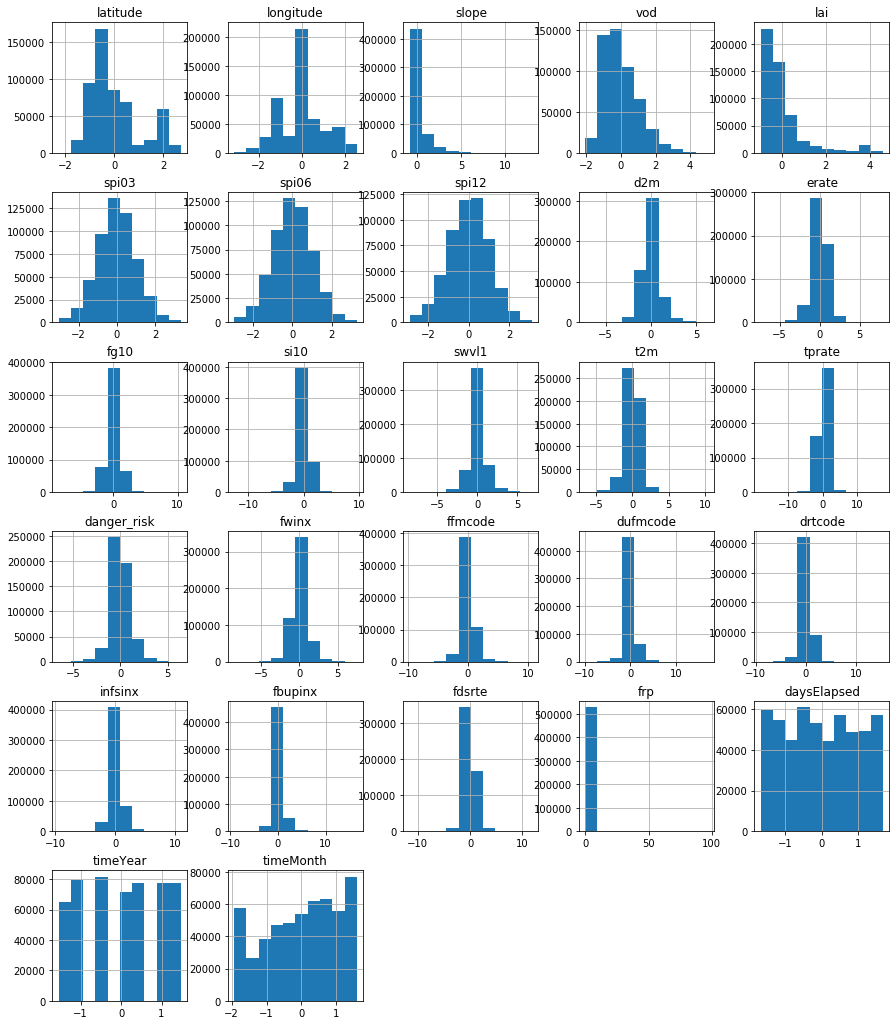

In [35]:
train_stand_all.drop(['log_dry_matter', 'climatic_region', 'biome', 'GFEDregions'],
                     axis = 1).hist(figsize = (15,18))

The above test shows that the best result is achieved by standardising the features and that there is no clear improvement in removing redundant features. This is an interesting interim result: ensuring that predictors vary in comparable ranges (standardisation) yields better results than correcting the variable distribution using a statistical transformation. Therefore, the final model makes use of a log-transformed target and all the features (standardised). 

In [36]:
train_stand_all.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/train_interpTrue_preprocessed.csv")
test_stand_all.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/test_interpTrue_preprocessed.csv")